In [4]:
import IPython
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from music21 import *
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *
from outputs import *

from tensorflow.keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


/opt/homebrew/Caskroom/miniforge/base/envs/mvenv/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [5]:
X, Y, n_values, indices_values, chords = load_music_utils('data/original_metheny.midi')
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('shape of X:', X.shape)
print('Shape of Y:', Y.shape)
print('Number of chords', len(chords))

number of training examples: 60
Tx (length of sequence): 30
total # of unique values: 90
shape of X: (60, 30, 90)
Shape of Y: (30, 60, 90)
Number of chords 19


In [6]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 64 

In [7]:
n_values = 90 # number of music values
reshaper = Reshape((1, n_values))                  # Used in Step 2.B of djmodel(), below
LSTM_cell = LSTM(n_a, return_state = True)         # Used in Step 2.C
densor = Dense(n_values, activation='softmax')     # Used in Step 2.D

In [8]:
def djmodel(Tx, LSTM_cell, densor, reshaper):
    """
    Implement the djmodel composed of Tx LSTM cells where each cell is responsible
    for learning the following note based on the previous note and context.
    Each cell has the following schema: 
            [X_{t}, a_{t-1}, c0_{t-1}] -> RESHAPE() -> LSTM() -> DENSE()
    Arguments:
        Tx -- length of the sequences in the corpus
        LSTM_cell -- LSTM layer instance
        densor -- Dense layer instance
        reshaper -- Reshape layer instance
    
    Returns:
        model -- a keras instance model with inputs [X, a0, c0]
    """
    # Get the shape of input values
    n_values = densor.units
    
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values)) 
    
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    # Create empty list to append the outputs while you iterate (≈1 line)
    outputs = []
    
    # Loop over tx
    for t in range(Tx):
        
        # select the "t"th time step vector from X. 
        x = X[:,t,:]
        # Use reshaper to reshape x to be (1, n_values) (≈1 line)
        x = reshaper(x)
        # Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs=x, initial_state=[a, c])
        # Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # add the output to "outputs"
        outputs.append(out)
        
    # Create model instance
    model = Model(inputs=[X, a0, c0], outputs=outputs)

    return model

In [9]:
model = djmodel(Tx=30, LSTM_cell=LSTM_cell, densor=densor, reshaper=reshaper)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 90)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 90)           0           input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 90)        0           tf.__operators__.getitem[0][0]   
                                                                 tf.__operators__.getitem_1[0][0] 
                                                                 tf.__operators__.getitem_2[0][0] 
                                                                 tf.__operators__.getitem_3[0]

In [11]:
# optimizer
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)
# loss function is categorical cross-entropy for multi-class classification
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# initialize LSTM's state
m = 60
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

In [13]:
history = model.fit([X, a0, c0], list(Y), epochs=100, verbose = 0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-08 14:39:46.016891: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-08 14:39:46.017199: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


loss at epoch 1: 129.8898468017578
loss at epoch 100: 9.450604438781738


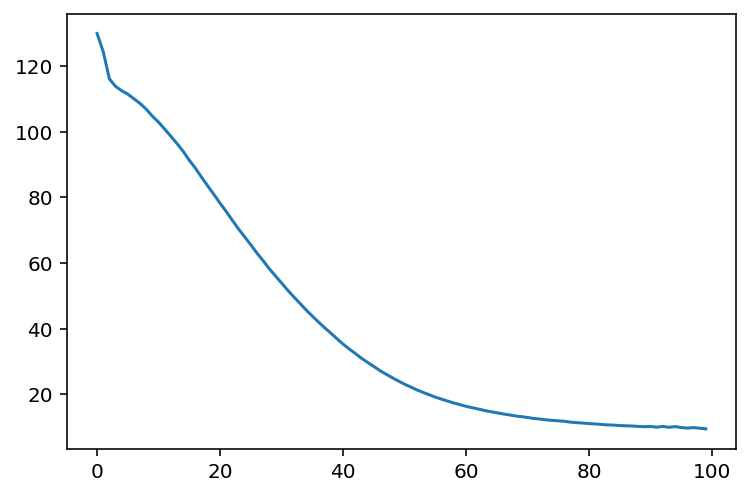

In [14]:
print(f"loss at epoch 1: {history.history['loss'][0]}")
print(f"loss at epoch 100: {history.history['loss'][99]}")
plt.plot(history.history['loss'])

In [15]:
def music_inference_model(LSTM_cell, densor, Ty=100):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    
    # Get the shape of input values
    n_values = densor.units
    # Get the number of the hidden state vector
    n_a = LSTM_cell.units
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    ### START CODE HERE ###
    # Step 1: Create an empty list of "outputs" to later store your predicted values (≈1 line)
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        # Perform one step of LSTM_cell. Use "x", not "x0" (≈1 line)
        a, _, c = LSTM_cell(x, initial_state=[a,c])    
        # Apply Dense layer to the hidden state output of the LSTM_cell (≈1 line)
        out = densor(a)
        # Append the prediction "out" to "outputs". out.shape = (None, 90) (≈1 line)
        outputs.append(out)
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = tf.math.argmax(out, axis=1)
        x = tf.one_hot(x, n_values)
        # Use RepeatVector(1) to convert x into a tensor with shape=(None, 1, 90)
        x = RepeatVector(1)(x)
        
    # Create model instance with the correct "inputs" and "outputs" (≈1 line)
    inference_model = Model(inputs=[x0, a0, c0], outputs=outputs)
    
    return inference_model

In [16]:
inference_model = music_inference_model(LSTM_cell, densor, Ty = 50)

In [17]:
# check the inference model 
inference_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1, 90)]      0                                            
__________________________________________________________________________________________________
a0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
c0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 64), (None,  39680       input_2[0][0]                    
                                                                 a0[0][0]                   

In [18]:
x_initializer = np.zeros((1, 1, n_values))
a_initializer = np.zeros((1, n_a))
c_initializer = np.zeros((1, n_a))

In [19]:
def predict_and_sample(inference_model, x_initializer = x_initializer, a_initializer = a_initializer, 
                       c_initializer = c_initializer):
    """
    Predicts the next value of values using the inference model.
    
    Arguments:
    inference_model -- Keras model instance for inference time
    x_initializer -- numpy array of shape (1, 1, 90), one-hot vector initializing the values generation
    a_initializer -- numpy array of shape (1, n_a), initializing the hidden state of the LSTM_cell
    c_initializer -- numpy array of shape (1, n_a), initializing the cell state of the LSTM_cel
    
    Returns:
    results -- numpy-array of shape (Ty, 90), matrix of one-hot vectors representing the values generated
    indices -- numpy-array of shape (Ty, 1), matrix of indices representing the values generated
    """
    
    n_values = x_initializer.shape[2]

    # Use the inference model to predict an output sequence given x_initializer, a_initializer and c_initializer.
    pred = inference_model.predict([x_initializer, a_initializer, c_initializer])
    # Convert "pred" into an np.array() of indices with the maximum probabilities
    indices = np.argmax(np.array(pred), axis=2)# pred is m,x<t>,n_values
    # Convert indices to one-hot vectors, the shape of the results should be (Ty, n_values)
    results = to_categorical(indices, num_classes=n_values)

    return results, indices

In [20]:
results, indices = predict_and_sample(inference_model, x_initializer, a_initializer, c_initializer)

print("np.argmax(results[12]) =", np.argmax(results[12]))
print("np.argmax(results[17]) =", np.argmax(results[17]))
print("list(indices[12:18]) =", list(indices[12:18]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
np.argmax(results[12]) = 35
np.argmax(results[17]) = 71
list(indices[12:18]) = [array([35]), array([21]), array([44]), array([25]), array([85]), array([71])]


In [21]:
out_stream = generate_music(inference_model, indices_values, chords)

Predicting new values for different set of chords.
Generated 39 sounds using the predicted values for the set of chords ("1") and after pruning
Generated 39 sounds using the predicted values for the set of chords ("2") and after pruning
Generated 39 sounds using the predicted values for the set of chords ("3") and after pruning
Generated 38 sounds using the predicted values for the set of chords ("4") and after pruning
Generated 39 sounds using the predicted values for the set of chords ("5") and after pruning
Your generated music is saved in output/my_music.midi


In [ ]:
#mid2wav('output/my_music.midi')
#IPython.display.Audio('./output/rendered.wav')